# Zillow Regression Project

<div class="alert alert-block alert-success"></div>

## Executive Summary



Model was able to predict home values within an error of $484,301.60
This represents a 26% improvement over baseline

*What are you going to do and how are you going to do it? Write out your thoughts here in a way that you can easily explain your work to members on your team.*

*This is your space to put together the elevator pitch for your project, and then follow it up with a plan of attack. It's going to be short, but that doesn't mean you won't need to spend much time putting it together -- this is a process of dropping the bad ideas until you're left with something that you are confident you can work with.*

*Don't take shortcuts here; coming up with a useful question and a straightforward work plan is going to make the rest of your project flow much more smoothly from start to finish.*

*One final, and very important, point: the main reason for thinking about this stage as how you're going to describe your work to others is that you should be talking about work with others!!! The more you work on your project in isolation, the better your ideas will sound to you -- even the bad ones. Listening to your ideas spoken out loud in your own voice is an excellent sanity check, and feedback from your peers is your most valuable resource.*

**You don't have to answer every question, but answer each that you can now and then come back later. Also, if the question doesn't apply, remove it.**

### Problem Statement

We want to be able to predict the values of single unit properties that the tax district assesses using the property data from those whose last transaction was during the "hot months" (in terms of real estate demand) of May and June in 2017.

#### Addidtional Reporting Requested

1. What state and county are these properties in?
2. Tax Rate for each property
3. Distribution of tax rates for each county
4. How much does the tax rate vary by county?
5. What tax rate do the bulk of the properties sit around?

This model will allow us to predict tax assessment values which is helpful when considering property purchase. 


### Work Plan
**Work Flow**   
Acquire data from Codeup Zillow database, clean and prepare   
Explore 3 variables for modeling (bedroomcnt, bathroomcnt, and calculatedfinishedsquarefeet)  
Use Chi Squared Test for Independence on bedroomcnt and bathroomcnt to determine dependence of features  
Construct a model to predict single unit property tax assessment value   
Evaluate model effectiveness  
Summarize Conclusions and next steps  

**Machine Learning(ML) Condsiderations**   
Model type is a Regression ML model  
Use all four common regression model types: Linear Regression, LassoLars, Polynomial Features, TweedieRegressor  
Models require numeric data must be scaled   
Establish Baseline based on target mean, if model Root Mean Squared Error (RMSE) is lower than the baseline the model performs better


<div class="alert alert-block alert-success"></div>

## Imports

In [1]:
import src.acquire
import src.prepare
import src.explore
import src.model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

<div class="alert alert-block alert-success"></div>

## Acquire the Data

### SQL Query synopsis

Select all columns from actual 2017 and join predictions 2017 to get the transaction date and filter for the months of May and June 2017 only. Then filter the results for only property use types that meet the deffinition of a single unit property. 

**Determine deffinition of single property**
used article by James Chen Updated Sep 11, 2020 What Is a Housing Unit?
"The term housing unit refers to a single unit within a larger structure that can be used by an individual or household to eat, sleep, and live. The unit can be in any type of residence such as a house, apartment, mobile home, or may also be a single unit in a group of rooms. Essentially, a housing unit is deemed to be a separate living quarter where the occupants live and eat separately from other residents of the structure or building. They also have direct access from the building's exterior or through a common hallway."

    https://www.investopedia.com/terms/h/housingunits.asp

**Identify Properties in the Database: Based on the above definition some categories do not fit brief**    
Propertylandusetypeid | propertylandusedesc    
  **No**        31           Commercial/Office/Residential Mixed Used  (not a residence)   
  **No**        46           Multi-Story Store                         (not a residence)   
  **No**        47           Store/Office (Mixed Use)                  (not a residence)   
            246          Duplex (2 Units, Any Combination)   
            247          Triplex (3 Units, Any Combination)   
            248          Quadruplex (4 Units, Any Combination)   
            260          Residential General   
            261          Single Family Residential   
            262          Rural Residence   
            263          Mobile Home   
            264          Townhouse   
            265          Cluster Home    
            266          Condominium   
  **No**        267          Cooperative                               (become shareholder not owner)   
            268          Row House
            269          Planned Unit Development   
  **No**        270          Residential Common Area                   (propterty feature)   
  **No**        271          Timeshare                                 (become shareholder not owner)  
            273          Bungalow
            274          Zero Lot Line   
            275          Manufactured, Modular, Prefabricated Homes   
            276          Patio Home    
            279          Inferred Single Family Residential
  **No**        290          Vacant Land - General                     (not a residence)   
  **No**        291          Residential Vacant Land                   (not a residence)   

<div class="alert alert-block alert-success"></div>

## Prepare the Data

**Feature Selection**   
What Data do we need in our inital df?   

parcelid 20931 non-null int64 Listing Number - Unique id, Drop   
id 20931 non-null int64 Listing ID - Drop   
airconditioningtypeid 6779 non-null float64 - Too Many null-values - Drop  
architecturalstyletypeid 52 non-null float64 - Too Many null-values - Drop   
basementsqft 16 non-null float64 16 non-values - Drop for Explore   
bathroomcnt 20931 non-null float64 **Use**   
bedroomcnt 20931 non-null float64 **Use** - Combine bath/bed (feature engeneering)   
buildingclasstypeid 0 non-null object - All Values Null - Drop   
buildingqualitytypeid 13257 non-null float64 - Too Many null-values - Drop   
calculatedbathnbr 20771 non-null float64 - Repeat of barthromcnt - Drop   
decktypeid 174 non-null float64 - Too Many null-values - Drop   
finishedfloor1squarefeet 1738 non-null float64 - Repeat Column - Drop   
calculatedfinishedsquarefeet 20868 non-null float64 **Use** - Drop nulls   
finishedsquarefeet12 20024 non-null float64 - Repeat Column - Drop for Explore   
finishedsquarefeet13 17 non-null float64 - Repeat Column - Drop    
finishedsquarefeet15 736 non-null float64 - Repeat Column - Drop    
finishedsquarefeet50 1738 non-null float64 - Repeat Column - Drop    
finishedsquarefeet6 91 non-null float64 - Repeat Column - Drop    
fips 20931 non-null float64 - **Use** - use for additional notebook    
fireplacecnt 2422 non-null float64 **Use** - change null to 0   
fullbathcnt 20771 non-null float64 - Repeat of bathroom - Drop   
garagecarcnt 7075 non-null float64 **Use** - Rename as garage, change null to 0   
garagetotalsqft 7075 non-null float64 - garagesqft verifys that they exist - Drop   
hashottuborspa 461 non-null float64 **Use** - change null to 0, for no ht or spa   
heatingorsystemtypeid 13285 non-null float64 - Too Many null-values - Drop   
latitude 20931 non-null float64 - **Use**n - use for additional notebook   
longitude 20931 non-null float64 - **Use** - use for additional notebook   
lotsizesquarefeet 18742 non-null float64 - Too Large for Modeling, Scaling?   
poolcnt 4496 non-null float64 Use **Use** - change null to 0, for no pool   
poolsizesum 251 non-null float64 - Repeat Column - Drop    
pooltypeid10 121 non-null float64 - Repeat Column - Drop    
pooltypeid2 340 non-null float64 - Repeat Column - Drop    
pooltypeid7 4154 non-null float64 - Repeat Column - Drop   
propertycountylandusecode 20931 non-null object - Repeat Column - Drop       
propertylandusetypeid 20931 non-null float64 **Use** - Categories   
propertyzoningdesc 13437 non-null object - Too Many null-values - Drop   
rawcensustractandblock 20931 non-null float64 - Repeat Column - Drop   
regionidcity 20503 non-null float64 - Repeat info(zip) - Drop   
regionidcounty 20931 non-null float64 Repeat info(zip) - Drop   
regionidneighborhood 8443 non-null float64 - Too Many null-values - Drop    
regionidzip 20916 non-null float64 **Use** - latered to categorical   
roomcnt 20931 non-null float64 **Use**   
storytypeid 16 non-null float64 - Too Many null-values - Drop   
threequarterbathnbr 2800 non-null float64 - Repeat info(bathroom) - Drop   
typeconstructiontypeid 56 non-null float64 - Too Many null-values - Drop    
unitcnt 13476 non-null float64 - Repeat info() - Drop    
yardbuildingsqft17 701 non-null float64 - Too Many null-values - Drop    
yardbuildingsqft26 25 non-null float64 - Too Many null-values - Drop    
yearbuilt 20850 non-null float64 **Use** - Drop null values, convert to year, category, then drop     
numberofstories 4917 non-null float64 - Too Many null-values - Drop    
fireplaceflag 51 non-null float64 - Repeat info(firepls) - Drop    
structuretaxvaluedollarcnt 20897 non-null float64 - Correlates w/Target - Drop   
taxvaluedollarcnt 20930 non-null float64 **Target Variable**   
assessmentyear 20931 non-null float64 - Filtered in SQL - Drop    
landtaxvaluedollarcnt 20930 non-null float64 - Correlates w/Target - Drop   
taxamount 20931 non-null float64 - **Use** - use for additional notebook    
taxdelinquencyflag 703 non-null object - Correlates w/Target - Drop    
taxdelinquencyyear 703 non-null float64 - Correlates w/Target - Drop    
censustractandblock 20852 non-null float64 - Repeat Column - Drop    
id 20931 non-null int64 - Repeat Column - Drop    
logerror 20931 non-null float64 - Calculation - Drop    
transactiondate 20931 non-null object - Filtered in SQL - Drop    

### Clean the Data

Rename columns for clarity: fireplace, hottub, garage    
Replace NaN values with 0 because property did not have feature if NaN was used     
Convert zip, parcelid, year to categorical values and assign codes using .astype and .cat     
Drop all columns except those needed for explore and modeling stages   
Drop outliers identified during tax rate calculation, total 14 oberservations, see Additional Information Notebook for strategy synopsis    
Drop any remaining null values   
Split data into train, validate, test   
Define dataframe for exploration (X_train_explore) based on train   
Define dataframes for scaling (X_train, X_validate, X_test) dropping target values and non-feature columns   
Define target dataframe for modeling (y_train, y_validate, y_test)   
Fit the scaler (MinMaxScaler used) to the X_train dataframe   
Transform the dataframes to return X_train_scaled, X_validate_scaled, X_test_scaled   


### Load created dataframes

In [2]:
path='zillow_df.csv'

df, X_train_explore, \
    X_train_scaled, y_train, \
    X_validate_scaled, y_validate, \
    X_test_scaled, y_test = src.prepare.wrangle_zillow(path)

X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((12216, 12), (5236, 12), (4364, 12))

<div class="alert alert-block alert-success"></div>

## Explore the Data

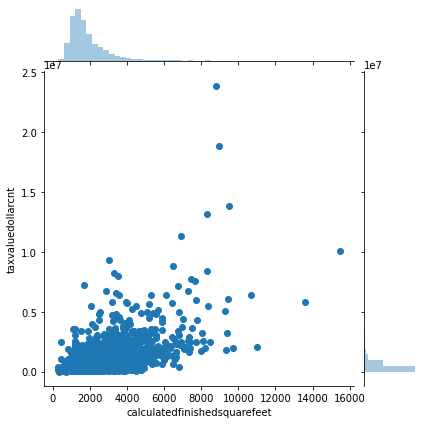

In [3]:
# Visualize relationship between square feet and tax value (Continuous and Continuous)
sns.jointplot(x='calculatedfinishedsquarefeet',y='taxvaluedollarcnt', data=X_train_explore)
plt.show()

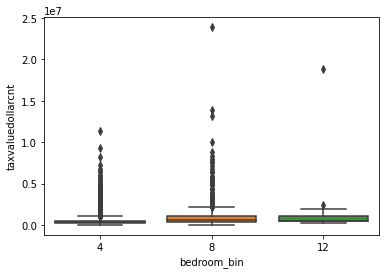

In [4]:
# Visualize relationship between bedroom count and tax value (Continuous and Categorical)
X_train_explore['bedroom_bin'] = pd.cut(X_train_explore.bedroomcnt, bins=[0, 4, 8, 12], labels=['4', '8', '12'])
sns.boxplot(data=X_train_explore, y='taxvaluedollarcnt', x='bedroom_bin')
plt.show()

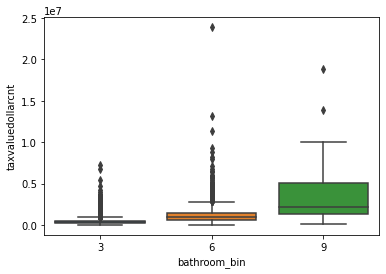

In [5]:
# Visualize relationship between bathroom count and tax value (Continuous and Categorical)
X_train_explore['bathroom_bin'] = pd.cut(X_train_explore.bathroomcnt, bins=[0, 3, 6, 9], labels=['3', '6', '9'])
sns.boxplot(data=X_train_explore, y='taxvaluedollarcnt', x='bathroom_bin')
plt.show()

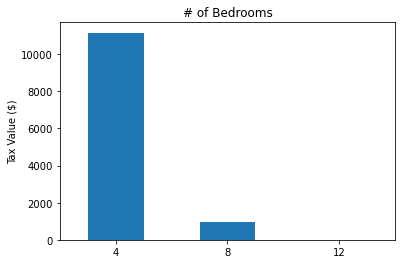

In [6]:
# Histogram of Bedrooms (Continuous and Categorical)

X_train_explore.bedroom_bin.value_counts().sort_index().plot.bar()
plt.title('# of Bedrooms')
plt.ylabel('Tax Value ($)')
plt.xticks(rotation=0)
plt.show()

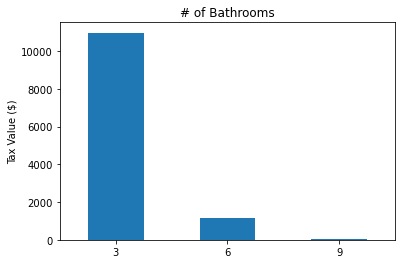

In [7]:
# Histogram of Bedrooms (Continuous and Categorical)
X_train_explore.bathroom_bin.value_counts().sort_index().plot.bar()
plt.title('# of Bathrooms')
plt.ylabel('Tax Value ($)')
plt.xticks(rotation=0)
plt.show()

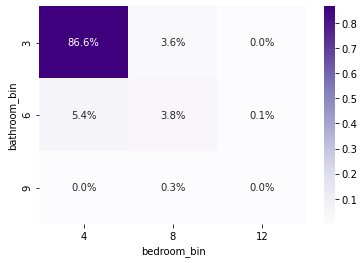

In [8]:
# Heatmap of bined values (Categorical and Categorical)
ctab = pd.crosstab(X_train_explore.bathroom_bin, X_train_explore.bedroom_bin, normalize=True)
sns.heatmap(ctab, cmap='Purples', annot=True, fmt='.1%')

***

#### Takeaway:

1. The only feature that appears to correlate wth the target in a linear fashion is calculatedfinishedsqure feet
2. Most housese have 3 or less bathrooms
3. Most houses have 3 or less bedrooms
4. High degree of correlation between bedrooms and bathrooms (in lower range of values), relationship to explore

***

<div class="alert alert-block alert-success"></div>

## Hypothesis Testing

#### Chi Squared Test For Independence:

**Hypothesis: There is a relationship between # of bedrooms and # of bathrooms that would make them a good canidate for future feature engeneering.**

Null Hypothesis: $H_{0}$: Number of Bedrooms and Number of Bathrooms are independent

Alternative Hypothesis: $H_{a}$: Number of Bedrooms and Number of Bathrooms are dependent



In [9]:
# Hypothesis Test

alpha = 0.05
contingency_table = pd.crosstab(X_train_explore.bedroomcnt, X_train_explore.bathroomcnt)

chi2, p, degf, expected = stats.chi2_contingency(contingency_table)

if p < alpha:
    print("We reject the null hypothesis")
    print(f'chi^2 = {chi2:.4f}')
    print(f'p     = {p:.4f}')
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis
chi^2 = 16327.1250
p     = 0.0000


#### Two Sample, two tailed T-Test: Does a large home correlate to haveing a fireplace?

**Hypothesis: There is a relationship between square footage and fireplaces that would make them a good canidate for future feature engeneering.**

Null Hypothesis: $H_{0}$: In terms of squre footage there is no difference between houses with or without a fireplace

Alternative Hypothesis: $H_{a}$: In terms of squre footage there is a difference between houses with or without a fireplace

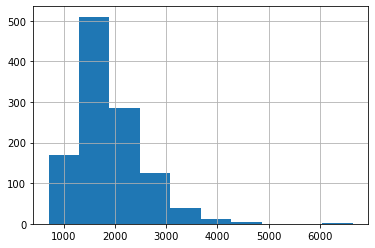

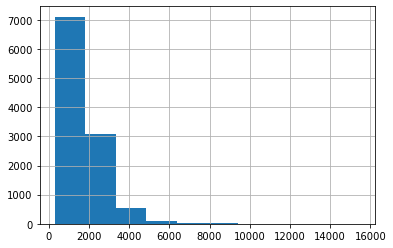

In [10]:
#Plot Distribution (normalize distribution)
fireplace = X_train_explore[X_train_explore.fireplace == 1]
no_fireplace = X_train_explore[X_train_explore.fireplace == 0]

fireplace['calculatedfinishedsquarefeet'].hist()
plt.show()
no_fireplace['calculatedfinishedsquarefeet'].hist()
plt.show()

In [11]:
# Variance (2 Sample T-Test)
print(fireplace.calculatedfinishedsquarefeet.var())
print(no_fireplace.calculatedfinishedsquarefeet.var())

406973.90039156756
916075.9647187777


In [12]:
#Compute T-Test
t, p = stats.ttest_ind(fireplace.calculatedfinishedsquarefeet, no_fireplace.calculatedfinishedsquarefeet, equal_var=False)
t, p

#Decide
if p < alpha and t > 0:
    print("We reject the null hypothesis")
    print(f't = {t:.4f}')
    print(f'p = {p:.4f}')
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis
t = 5.5944
p = 0.0000


***

#### Takeaway:

- Reject null, there is a difference between houses with or without a fireplace
- Fireplace and square footage are correlated

***

<div class="alert alert-block alert-success"></div>

## Evaluate Linear Features
This verifies the features we chose are statistically significant   
(Calculated for MVP features)

### First up lets use SelectKBest to see what our best features are

Select the K best features using a statistical test to compare each X with y and find which X's have the strongest relationship with y

In [13]:
top_3 = SelectKBest(f_regression, k=3).fit(X_train_scaled, y_train)

top_3_support = top_3.get_support()

X_train_scaled.loc[:,top_3_support].columns.tolist()

['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']

### Next lets run RFE to see what it says
Recursive Feature Elimination will create a model with all the features, evaluate the performance metrics, find the weakest feature, remove it, then create a new model with the remaining features, evaluate the performance metrics, find the weakest feature, remove it, and so on, until it gets down to the number of features you have indicated you want when creating the rfe object. 

In [14]:
lm = LinearRegression()
rfe = RFE(lm, 1)
rfe.fit(X_train_scaled, y_train)
ranks = rfe.ranking_
names = X_train_scaled.columns.tolist()
pd.DataFrame({'features': names, 'rank': ranks}).set_index('rank')

,features
rank,
3,bathroomcnt
2,bedroomcnt
1,calculatedfinishedsquarefeet
6,fireplace
4,garage
10,hottub_spa
7,lotsizesquarefeet
11,poolcnt
12,roomcnt


***

### Takaway:

- All 3 Variables pass F-test and are significant to use in our modeling
- Features not well suited for linear model (low r-squared), try polynomial features model

***

<div class="alert alert-block alert-success"></div>

## Model the Data


MVP - 3 Features
1. calculatedfinishedsquarefeet
2. bedroomcnt
3. bathroomcnt

Target = taxvaluedollarcnt

Use all four common regression model types: Linear Regression, LassoLars, Polynomial Features, TweedieRegressor  

Establish Baseline based on target mean, if model Root Mean Squared Error (RMSE) is lower than the baseline the model performs better 

### Create a Baseline

In [15]:
#Visualize Target
mean = np.mean(y_train)
median = np.median(y_train)

In [16]:
print("The mean value of y_train is")
mean

The mean value of y_train is


taxvaluedollarcnt    502918.070236
dtype: float64

In [17]:
print("The median value of y_train is")
median

The median value of y_train is


366533.0

In [18]:
y_train.describe()

,taxvaluedollarcnt
count,1.221600e+04
mean,5.029181e+05
std,6.590332e+05
min,1.108900e+04
25%,2.120292e+05
50%,3.665330e+05
75%,5.850000e+05
max,2.385837e+07


***

### Takaway:

- Variability in target suggest we use mean as baseline.
- Mean is more susceptable to outliers and thus better predicts skeweed data

***

In [19]:
# Mean Value
np.mean(y_train)
y_train.shape

(12216, 1)

In [20]:
# encode as variable
# np.full modiefies shape turns value in to a full series object
baseline_rmse = mean_squared_error(y_train, np.full(12216, np.mean(y_train)))**(1/2)
baseline_rmse  # Model Error To Beat $659,006.19

659006.1919428958

### Specify Variables for Modeling

In [21]:
# Only use bedroomcnt, bathroomcnt, and calculatedfinishedsquarefeet
# x df's are all numeric cols except tip
X_train_scaled = X_train_scaled.drop(columns=['fireplace', 'garage', 'hottub_spa', 'lotsizesquarefeet', 'poolcnt',
       'roomcnt', 'zip_cc', 'useid_cc', 'year_cc'])
X_validate_scaled = X_validate_scaled.drop(columns=['fireplace', 'garage', 'hottub_spa', 'lotsizesquarefeet', 'poolcnt',
       'roomcnt', 'zip_cc', 'useid_cc', 'year_cc'])
X_test_scaled = X_test_scaled.drop(columns=['fireplace', 'garage', 'hottub_spa', 'lotsizesquarefeet', 'poolcnt',
       'roomcnt', 'zip_cc', 'useid_cc', 'year_cc'])

In [22]:
# Verify dataframe
X_train_scaled.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'], dtype='object')

### Train the Models

#### Linear Regression

In [23]:
# Make Model
lm = LinearRegression(normalize=True)
# Fit Model
lm.fit(X_train_scaled, y_train)
# Make Predictions
lm_pred = lm.predict(X_train_scaled)
# Compute root mean squared error
lm_rmse = mean_squared_error(y_train, lm_pred)**(1/2)
lm_rmse

520634.5005526053

#### LassoLars

In [24]:
# Make a model
lars = LassoLars(alpha=1)
# Fit a model
lars.fit(X_train_scaled, y_train)
# Make Predictions
lars_pred = lars.predict(X_train_scaled)
# Computer root mean squared error
lars_rmse = mean_squared_error(y_train, lars_pred)**(1/2)
lars_rmse

520634.57558119384

#### Polynomial Features

In [25]:
# Make a model
pf = PolynomialFeatures(degree=2)

# Fit and Transform model
# to get a new set of features..which are the original features sqauared
X_train_squared = pf.fit_transform(X_train_scaled)
X_validate_squared = pf.transform(X_validate_scaled)
X_test_squared = pf.transform(X_test_scaled)

# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_train_squared, y_train)
# Make predictions
lm_squared_pred = lm_squared.predict(X_train_squared)
# Compute root mean squared error
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
lm_squared_rmse

503340.82626955665

#### Tweedie Regressor

In [26]:
# Make Model
tw = TweedieRegressor(power=0, alpha=0.1) # 0 = normal distribution
# Fit Model
tw.fit(X_train_scaled, y_train)
# Make Predictions
tw_pred = tw.predict(X_train_scaled)
# Compute root mean squared error
tw_rmse = mean_squared_error(y_train, tw_pred)**(1/2)
tw_rmse

635035.2731805356

***
#### Takeaway:
- Top 3 preforming models are Linear, LassoLars, and Polynomial
- These modes will move on to Validate
***

### Validate the 3 Best Performing Models

#### Linear Regression

In [27]:
# Make Predictions
lm_pred_v = lm.predict(X_validate_scaled)
# Compute root mean squared error
lm_rmse_v = mean_squared_error(y_validate, lm_pred_v)**(1/2)
lm_rmse_v

486307.6079205688

#### LassoLars

In [28]:
# Make predictions
lars_pred_v = lars.predict(X_validate_scaled)
# Compute root mean squared error
lars_rmse_v = mean_squared_error(y_validate, lars_pred_v)**(1/2)
lars_rmse_v

486303.12943566113

#### Ploynomial Features

In [29]:
# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_validate_squared, y_validate)
# Make predictions
lm_squared_pred_v = lm_squared.predict(X_validate_squared)
# Compute root mean squared error
lm_squared_rmse_v = mean_squared_error(y_validate, lm_squared_pred_v)**(1/2)
lm_squared_rmse_v

460557.3256277409

***
### Takeaway:
- On unseen data the Polynomial Model performs the best and will move on to the test data
***

### Test the Best Performing Model

#### Polynomial Features

In [30]:
# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_test_squared, y_test)
# Make predictions
lm_squared_pred_t1 = lm_squared.predict(X_test_squared)
# Compute root mean squared error
lm_squared_rmse_t1 = round(mean_squared_error(y_test, lm_squared_pred_t1)**(1/2),2)
lm_squared_rmse_t1

469438.17

#### Average Model Error (Validate + Test) / 2

In [31]:
# Avg. Error = (Validate Error + Test Error) /2 - Average preformance of model works on unseen data
model_error = round((lm_squared_rmse_v + lm_squared_rmse_t1) / 2 , 2)
print(f'The average error for our model is ${model_error}')

The average error for our model is $464997.75


#### Percentage Improvement over Baseline

In [32]:
# Calcuating % improvement
# First: work out the difference (increase) between the two numbers you are comparing
difference = (baseline_rmse - lm_squared_rmse_t1)
# Then: divide the increase by the original number and multiply the answer by 100
percent_improve = round((difference / baseline_rmse) * 100, 2)
print(f'The % improvement for our model is {percent_improve}%')

The % improvement for our model is 28.77%


***

### Takeaway:
- Polynomial Features is the model that best predicts tax assessed value
- This model produces an average error of $464997.75
- This represents a **29%** improvement over baseline

***

<div class="alert alert-block alert-success"></div>

## Can we improve model preformance using different input variables?

In [33]:
# Refresh data for new round of modeling
path='zillow_df.csv'

df, X_train_explore, \
    X_train_scaled, y_train, \
    X_validate_scaled, y_validate, \
    X_test_scaled, y_test = src.prepare.wrangle_zillow(path)

#### RFE review (key features)

In [34]:
lm = LinearRegression()
rfe = RFE(lm, 1)
rfe.fit(X_train_scaled, y_train)
ranks = rfe.ranking_
names = X_train_scaled.columns.tolist()
pd.DataFrame({'features': names, 'rank': ranks}).set_index('rank')

,features
rank,
3,bathroomcnt
2,bedroomcnt
1,calculatedfinishedsquarefeet
6,fireplace
4,garage
10,hottub_spa
7,lotsizesquarefeet
11,poolcnt
12,roomcnt


***

### Takaway:
- Variables with greatest correlation to target
  - calculatedfinishedsquarefeet
  - bedroomcnt
  - bathroomcnt
  - garage
  - zip_cc

- All models pass F-Test w/ p-value of < 0.05 and can be used for modeling

- Variables have high correlation and low r-squred values, indicates they may improve out polynomial features model
***

<div class="alert alert-block alert-success"></div>

## Model the Data (2nd Iteration)

Polynomial Features Model - 5 Features (degrees = 2)

1. calculatedfinishedsquarefeet
2. bedroomcnt
3. bathroomcnt
4. garage
5. zip_cc

Target = taxvaluedollarcnt 

Establish Baseline based on target mean, if model Root Mean Squared Error (RMSE) is lower than the baseline the model performs better 

### Create a Baseline

In [35]:
# Mean Value
np.mean(y_train)
y_train.shape

(12216, 1)

In [36]:
# encode as variable
# np.full modiefies shape turns value in to a full series object
baseline_rmse = mean_squared_error(y_train, np.full(12216, np.mean(y_train)))**(1/2)
baseline_rmse  # Model Error To Beat $659,006.19

659006.1919428958

### Specify Variables for Modeling

In [37]:
# Refresh data for new round of modeling
path='zillow_df.csv'

df, X_train_explore, \
    X_train_scaled, y_train, \
    X_validate_scaled, y_validate, \
    X_test_scaled, y_test = src.prepare.wrangle_zillow(path)

In [38]:
X_train_scaled.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fireplace', 'garage', 'hottub_spa', 'lotsizesquarefeet', 'poolcnt',
       'roomcnt', 'zip_cc', 'useid_cc', 'year_cc'],
      dtype='object')

In [39]:
# Only use bedroomcnt, bathroomcnt, and calculatedfinishedsquarefeet
# x df's are all numeric cols except tip
X_train_scaled = X_train_scaled.drop(columns=['fireplace','lotsizesquarefeet','hottub_spa','poolcnt','roomcnt','useid_cc','year_cc'])
X_validate_scaled = X_validate_scaled.drop(columns=['fireplace','lotsizesquarefeet','hottub_spa','poolcnt','roomcnt','useid_cc','year_cc'])
X_test_scaled = X_test_scaled.drop(columns=['fireplace','lotsizesquarefeet','hottub_spa','poolcnt','roomcnt','useid_cc','year_cc'])

In [40]:
X_train_scaled.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'garage',
       'zip_cc'],
      dtype='object')

### Train the Model

In [41]:
# Make a model
pf = PolynomialFeatures(degree=2)

# Fit and Transform model
# to get a new set of features..which are the original features sqauared
X_train_squared = pf.fit_transform(X_train_scaled)
X_validate_squared = pf.transform(X_validate_scaled)
X_test_squared = pf.transform(X_test_scaled)

# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_train_squared, y_train)
# Make predictions
lm_squared_pred = lm_squared.predict(X_train_squared)
# Compute root mean squared error
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
lm_squared_rmse

483296.69612910505

### Validate the Model

In [42]:
# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_validate_squared, y_validate)
# Make predictions
lm_squared_pred_v = lm_squared.predict(X_validate_squared)
# Compute root mean squared error
lm_squared_rmse_v = mean_squared_error(y_validate, lm_squared_pred_v)**(1/2)
lm_squared_rmse_v

440057.96018437896

### Test the Model

In [43]:
# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_test_squared, y_test)
# Make predictions
lm_squared_pred_t2 = lm_squared.predict(X_test_squared)
# Compute root mean squared error
lm_squared_rmse_t2 = round(mean_squared_error(y_test, lm_squared_pred_t2)**(1/2),2)
lm_squared_rmse_t2

454020.85

#### Average Model Error (Validate + Test) / 2

In [44]:
# Avg. Error = (Validate Error + Test Error) /2 - Average preformance of model works on unseen data
model_error = round((lm_squared_rmse_v + lm_squared_rmse_t2) / 2 , 2)
print(f'The average error for our model is ${model_error}')

The average error for our model is $447039.41


#### Percentage Improvement over Baseline

In [45]:
# Calcuating % improvement
# First: work out the difference (increase) between the two numbers you are comparing
difference = (baseline_rmse - lm_squared_rmse_t2)
# Then: divide the increase by the original number and multiply the answer by 100
percent_improve = round((difference / baseline_rmse) * 100, 2)
print(f'The % improvement for our model is {percent_improve}%')

The % improvement for our model is 31.11%


***

### Takaway:

- Model with new feature produced better RMSE = better model
- 3rd iteration refine hyperparameters (degrees = )


***

<div class="alert alert-block alert-success"></div>

## Model the Data (3rd Iteration)

Polynomial Features Model - 5 Features (degrees = 5)

1. calculatedfinishedsquarefeet
2. bedroomcnt
3. bathroomcnt
4. garage
5. zip_cc

Target = taxvaluedollarcnt 

Establish Baseline based on target mean, if model Root Mean Squared Error (RMSE) is lower than the baseline the model performs better 

### Train the Model

In [46]:
# Make a model
pf = PolynomialFeatures(degree=3)

# Fit and Transform model
# to get a new set of features..which are the original features sqauared
X_train_squared = pf.fit_transform(X_train_scaled)
X_validate_squared = pf.transform(X_validate_scaled)
X_test_squared = pf.transform(X_test_scaled)

# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_train_squared, y_train)
# Make predictions
lm_squared_pred = lm_squared.predict(X_train_squared)
# Compute root mean squared error
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
lm_squared_rmse

463324.86752014764

### Validate the Model

In [47]:
# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_validate_squared, y_validate)
# Make predictions
lm_squared_pred_v = lm_squared.predict(X_validate_squared)
# Compute root mean squared error
lm_squared_rmse_v = mean_squared_error(y_validate, lm_squared_pred_v)**(1/2)
lm_squared_rmse_v

431388.7299990621

### Test the Model

In [48]:
# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_test_squared, y_test)
# Make predictions
lm_squared_pred_t3 = lm_squared.predict(X_test_squared)
# Compute root mean squared error
lm_squared_rmse_t3 = round(mean_squared_error(y_test, lm_squared_pred_t2)**(1/2),2)
lm_squared_rmse_t3

454020.85

#### Average Model Error (Validate + Test) / 2

In [49]:
# Avg. Error = (Validate Error + Test Error) /2 - Average preformance of model works on unseen data
model_error = round((lm_squared_rmse_v + lm_squared_rmse_t3) / 2 , 2)
print(f'The average error for our model is ${model_error}')

The average error for our model is $442704.79


#### Percentage Improvement over Baseline

In [50]:
# Calcuating % improvement
# First: work out the difference (increase) between the two numbers you are comparing
difference = (baseline_rmse - lm_squared_rmse_t3)
# Then: divide the increase by the original number and multiply the answer by 100
percent_improve = round((difference / baseline_rmse) * 100, 2)
print(f'The % improvement for our model is {percent_improve}%')

The % improvement for our model is 31.11%


***

### Takeaway:

- Model preformance decreased on unseen data (Train)
- Suggests overfitting

***

<div class="alert alert-block alert-success"></div>

## Conclusion

### Summary:

***

Exploration:   
- Top 5 variables for modeling (bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, garage, zip_cc)
- Validated using SlectKBest and RFE
- Variables passed F-Test with p-value < 0.05, indicating 95% certainty the indipendent variables explains the relationship (r-value)

***

Statistical Testing:   
- Chi Squared Test for Independence: bedroomcnt and bathroomcnt 
  - Rejected Null: 95% Confidence Variabes show dependence     
- Independent T-Test: Preformed on fireplace and total square feet 
  - Rejected Null: 95% Confidence that there is a difference (in terms of square footage) between houses with or without a fireplace   
  
***

Modeling: (3 Iterations)  
- 4 model: Linear Regression, LassoLars, Polynomial Features, TweedieRegressor   
  - Target = taxvaluedollarcnt   
    
    
1. First Iteration (3 Features, degree = 2)   
Features = bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet   
Best Model = Polynomial Feature Model    
Avg. RMSE of $464997.75   
**28% Improvement over baseline**    
  
  
2. Second Iteration (5 Features, degree = 2)   
Features = bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, garage, zip_cc   
Model = Polynomial Feature Model    
Avg. RMSE of $447039.41    
**31% Improvement over baseline**       
*Effect On Model - RFE Features Improve Preformance*   


3. Third Iteration (5 Features, degree = 5)
Features = bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, garage, zip_cc
Model = Polynomial Features Model   
Avg. RMSE of $442704.79  
**31% Improvement over baseline**   
*Effect On Model - Overfit, loss of predictive power on unseen data*   

<div class="alert alert-block alert-success"></div>

## Next Steps: What Can We Do Now?


New features for Model: 
Increasing the number of features in our model from 3 to 5 improved model preformance.  However this preformance may be further increased by combining some of our top features.  With more time we would like to invesigate some engeered featues such as a combined bedroom/bathroom.  